# Visualization work in progress

In [1]:
#%matplotlib notebook
import sys
import os
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipywidgets import *

%matplotlib inline

project_path = os.path.abspath(os.path.join('..'))

## Rough Plan

* 0) download / whatever data
* 1) visualize countywide data
* 2) graph a relevant trend for chosen zip (ideally some merge of KC and redfin)
* 3) graph a subtrend or subset of merged dataset

## Issues / to-do

* Currently running on base dataframes, not merged - addresses are not in the KC
* No geo location in KC - not even zip
* FYI No date in redfin - means that trend data will come from merge with KC?
* Choose function or interactive approach
* Split out aggregation functions along with merge functions into seperate .py files to make easier
* Tidy up visualizations - leged, formatting, size 

## Load and prep data for the dummy examples

In [2]:
#read redfin data
redfin_df = pd.read_csv(project_path+ "/data/redfin/All_King_Redfin.csv")

#convert to geodatafrmae for easy merging
gdf = gpd.GeoDataFrame(redfin_df, geometry=gpd.points_from_xy(redfin_df.LONGITUDE, redfin_df.LATITUDE))

#read kc data
kc_df = pd.read_csv(project_path+ "/data/kc/sample_kc_data.csv")

#convert kc date column to dates
kc_df['Document Date']= kc_df['Document Date'].astype('datetime64[ns]')

#pull in zip shapefiles
df_zip_shape = gpd.read_file("https://opendata.arcgis.com/datasets/06da0f67fc1948e3aae93063750ad02b_790.geojson")

#cut down zip file to geometry only to make easier to handle
df_n_c_small = df_zip_shape[['ZIP', 'geometry']]


/home/richard/miniconda3/envs/env515a/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (34,100,112,114,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Aggregate data for joining - may want to rehome this code

In [3]:
#aggregate meaningful redfin variables
zip_aggs = gpd.sjoin(df_n_c_small, gdf).groupby("ZIP").agg({'PRICE':'mean', 'DAYS ON MARKET':'mean', 
                                                                        'SQUARE FEET':'mean'})

#merge aggregated redfin with with zip dataframe
merged = df_n_c_small.merge(zip_aggs, on='ZIP')

#aggregate KC  by dateZIP IS NOT IN YET
kc_aggregate = kc_df.groupby(["Document Date"]).agg({'Sale Price':'mean',
                          'Excise Tax Number':'nunique'})
#remove any miscodes (some dates in 2070)
kc_aggregate = kc_aggregate[kc_aggregate.index < datetime.datetime.now()]

/home/richard/miniconda3/envs/env515a/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  warn(


## Plotting - either use functions or use interactive

In [4]:
#define opening map as a function in case want to split apart
def opening_plot(opening_data = merged, mapping_var='PRICE'):
    f, ax = plt.subplots(1)
    opening_data.plot(column=mapping_var,ax=ax, linewidth=0.5, edgecolor='0.5', legend=True)
    ax.set_axis_off()
    plt.axis('equal')
    plt.title('Mean sales price by zipcode (all transactions)')
    plt.savefig(project_path+'/output/example_opening.png');
    plt.show()

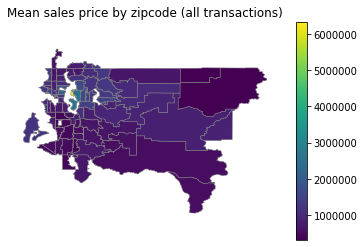

In [5]:
#plot with function
opening_plot()

In [6]:
#interactive opening plot - select var of interest
def opening_interactive(mapping_var='PRICE'):
    f, ax = plt.subplots(1)
    merged.plot(column=mapping_var,ax=ax, linewidth=0.5, edgecolor='0.5', legend=True)
    ax.set_axis_off()
    plt.axis('equal')

In [7]:
interactive_plot = interactive(opening_interactive, mapping_var=merged.select_dtypes(include=np.number).columns.tolist())
interactive_plot

interactive(children=(Dropdown(description='mapping_var', index=1, options=('ZIP', 'PRICE', 'DAYS ON MARKET', …

In [8]:
#define trend plot as a function in case want to split
def trend_plot(data=kc_aggregate, trend_variable='Sale Price'):
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (15,10)
    ax = plt.axes()
    x = data.index
    y=data[trend_variable]
    ax.plot(x, y)
    plt.title('Mean sales for selected dates (all transactions)')
    ax.set_xlim([datetime.date(2017, 1, 1), max(kc_aggregate.index)])
    ax.set_ylim([0,2000000]) 
    plt.savefig(project_path+'/output/example_trend.png');

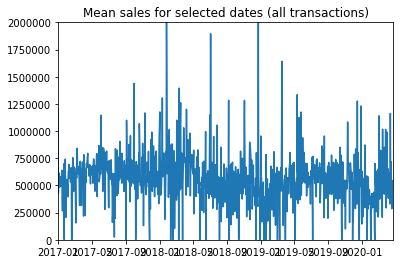

In [9]:
#plot with function
trend_plot()

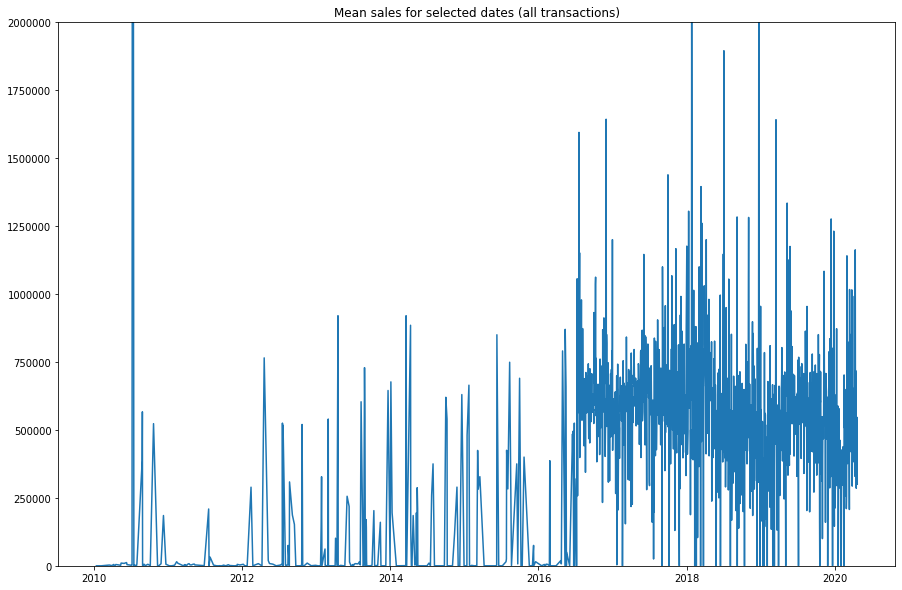

interactive(children=(IntSlider(value=2, description='years', max=6, min=-2), Output()), _dom_classes=('widget…

In [10]:
#interactive trend plot - x range
fig = plt.figure()
ax = plt.axes()
x = kc_aggregate.index
y = kc_aggregate['Sale Price']
ax.plot(x, y)
#ax.set_xlim([min(date_range), max(date_range)])

plt.title('Mean sales for selected dates (all transactions)')
ax.set_ylim([0,2000000])

def update(years = 2):
    ax.set_xlim([datetime.date(2020-years, 1, 1),max(kc_aggregate.index)])
    fig.canvas.draw_idle()

interact(update);

In [11]:
#interactive trend plot - select var of interest

def g(y):
    plt.plot(kc_aggregate.index, kc_aggregate[y])
    plt.show()

interactive_plot = interactive(g, y=kc_aggregate.columns)
interactive_plot

interactive(children=(Dropdown(description='y', options=('Sale Price', 'Excise Tax Number'), value='Sale Price…

## WIP - awaiting joined file structure

In [12]:
test_df = pd.read_csv(project_path+ "/data/kc/sample_data_98105_2019.csv")
import join_county_redfin
list(test_df.columns)
join_county_redfin.join_county_redfin(test_df,redfin_df)


/home/richard/miniconda3/envs/env515a/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (99,111,128) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


KeyError: 'Passed kc_data does not contain required columns:Major, Minor, Address, and ZipCode'